### Ambientes que a Gym oferece

Os oferecidos nativamente são divididos em categorias, sendo as principais: Atari, controle clássico, MuJoCo, robóticos , jogos de texto e Box2D. Vamos ver a seguir um exemplo de cada uma delas.

### Atari

Jogos clássicos convertidos para um formato que é possível treinar o agente.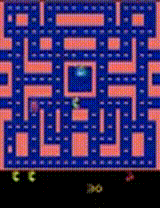

### Controle clássico

Problemas clássicos de mecânica que estão presentes na literatura de RL há bastante tempo. Uma das vantagens de usar Gym para esses problemas é que, como há uma consistência do meio utilizado, fica mais fácil comparar os resultados de estudos diferentes desenvolvidos no mesmo ambiente.

No exemplo a seguir, tem-se um veículo com um motor que não é forte o suficiente para subir o morro maior sem um auxílio externo. O agente deve, portanto, aprender a aumentar sua energia potencial subindo o morro menor para assim ter energia mecânica suficiente para subir o morro maior.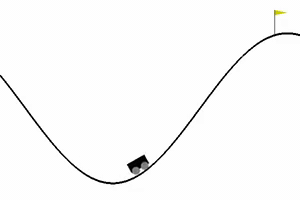

### Box2D

Ambientes feitos com base no simulador de física bidimensional Box2D. As tarefas em questão são contínuas, ou seja, não possuem um fim bem definido.

Neste exemplo, ensinamos um robô bípede a andar.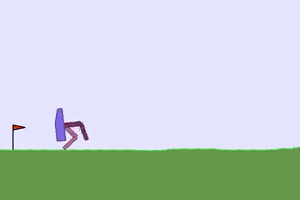

### MuJoCo

Baseados em uma engine física com foco em simulações de biomecânica, articulações, gráficas e animação. Aqui também temos tarefas contínuas.

No exemplo a seguir, temos um ambiente tridimensional no qual ensinamos um robô de 4 patas a andar.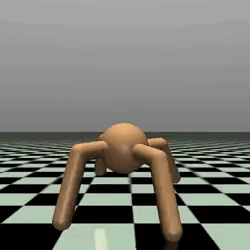


### Robóticos

Ambiente que simula membros robóticos (uma mão ou uma garra) motivados por tarefas com metas bem definidas.

No exemplo a seguir, uma mão robô manipula um bloco de madeira.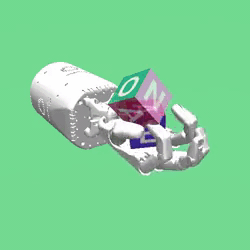

### Jogos de texto

Jogos simples com gráficos feito a partir de texto apenas.

Aqui temos o jogo do táxi. O objetivo é recolher um passageiro num determinado ponto e deixá-lo em outro. Caso o passageiro for deixado em um local errado, o jogador é penalizado.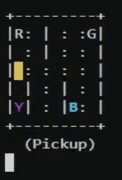

### Parte prática

Para nosso exemplo prático, vamos ensiná-lo a aplicar Q-learning no jogo do táxi. Escolhemos esse algoritmo por ser um dos mais básicos de RL, o que facilitará o entendimento e a aplicação. Utilizaremos o jogo do táxi pois conseguimos mapear todos os estados possíveis, característica essencial para a aplicação de Q-learning.

### Regras do jogo

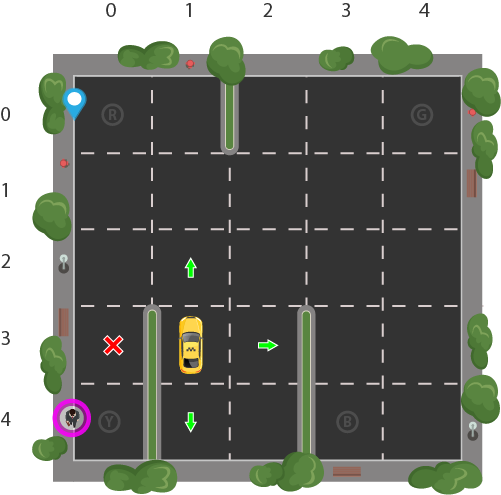

Há 4 localizações (nomeadas por letras diferentes). Nosso trabalho é pegar um passageiro em um local e deixá-lo em outro. Nós recebemos +20 pontos por destino correto e -1 ponto para cada passo tomado. Há também -10 pontos de penalidade para tentativas de embarque e desembarque erradas.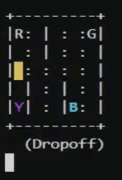
    
Na representação do ambiente, o retângulo colorido é o táxi, amarelo quando estiver vazio e verde quando estiver com passageiro.

As barras (“|”) representam paredes as quais o táxi não pode atravessar.

R, G, B e Y representam os pontos de embarque e desembarque. A letra azul representa a origem do passageiro e a letra roxa representa o destino.

### Espaço de estados

Precisamos definir o universo de todos os estados (situação atual e imediata do jogo) possíveis do agente no ambiente. Esse número é finito, então vamos calculá-lo. O tabuleiro é uma malha 5x5, o que permite 25 posições diferentes para o veículo. Há 4 locais (R, G, B e Y) de embarque e ainda o próprio carro como localização disponível para o passageiro habitar, o que contabiliza 5 lugares possíveis. Para finalizar a viagem, há 4 destinos diferentes (R, G, B e Y), portanto, vem:

5 x 5 x 5 x 4 = 500 estados possíveis!

Podemos representar qualquer sequência de eventos imaginável com esses 500 estados. Ficou surpreso com o resultado?


### Espaço de ações

As ações que podem ser tomadas em cada estado são:

   0 = sul
   1 = norte
   2 = leste
   3 = oeste
   4 = embarcar
   5 = desembarcar
            

Observe que sempre que o carro tentar atravessar uma parede o agente receberá uma penalidade de -1 e continuará no mesmo estado que estava anteriormente.


### Implementando com a biblioteca

Para começar este nosso exemplo vamos precisar de um ambiente de trabalho. Recomendo o Jupyter Notebook, mas você pode usar o de sua preferência.


### Importando as bibliotecas


In [8]:
import numpy as np
import gym
import random
from IPython.display import clear_output
from time import sleep

Agora, temos nosso espaço de trabalho configurado e pronto para uso. Precisamos entender melhor alguns dos métodos e objetos principais da biblioteca Gym.

In [14]:
env = gym.make("Taxi-v3").env #Essa linha carrega o ambiente que vamos usar, no nosso caso “Taxi-v3”. Ele fica salvo na variável env.
env.render() #Com esse método .render(), renderizamos o estado atual do ambiente.

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Outros métodos também muito importantes são:

env.reset: Reseta o ambiente e retorna um estado inicial aleatório.
env.step (action): Executa uma ação (passo). Retorna:

* observation: observações do ambiente.

* reward: recompensa recebida após a ação tomada.

* done: indica se foi o fim de um episódio. Acontece quando um passageiro embarca no táxi e desembarca no local correto.

* info: informação adicional para debbuging. O agente não tem acesso a elas.

Podemos também conferir as dimensões do espaço de ações e espaço de estados, da seguinte forma:

In [10]:
print(env.action_space)
print(env.observation_space)

Discrete(6)
Discrete(500)


### Q-learning

Vamos agora recordar das recompensas para cada ação. Elas já estão pré-definidas na biblioteca da seguinte maneira:

   +20 para um desembarque correto.
   -10 para um embarque ou desembarque incorreto.
   -1 para ações que não sejam as duas anteriores.

A recompensa de -1 é importante pois garante que o carro evite paredes (caso fique tentando entrar em uma, irá receber -1 indefinidamente) e que o agente busque se otimizar de forma a performar o menor caminho possível até o ponto de desembarque.

Precisamos determinar os q-values para cada tupla (estado, ação), que irão orientar a política do nosso agente, ou seja 500 x 6 = 3.000 valores. A partir da equação de Bellman, determinamos os q-values como segue:
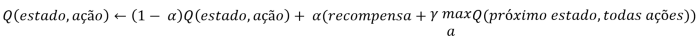

Onde:

   α é a taxa de aprendizado (0 < α ≤ 1), que representa o quanto nosso q-value está sendo atualizado em cada iteração.
   γ é o fator de desconto (0 < γ ≤ 1), que representa a importância que damos para recompensas futuras. γ próximo de 1 favorece as recompensas mais distantes enquanto gama perto de 0 praticamente às desconsidera.

O que estamos fazendo é atualizar o q-value da ação tomada no estado atual. Tomamos o valor antigo com um peso de (1- α) e adicionamos o novo valor aprendido, que é a combinação da recompensa por realizar a ação tomada no estado atual, com recompensa máxima, descontada (γ), do próximo estado que estaremos assim que tomarmos a ação.

Essa política fará com que o agente tome a rota que fornecerá a maior soma de recompensas possível.

### Tabela-Q

Para guardar esses valores vamos criar uma tabela Estados x Ações: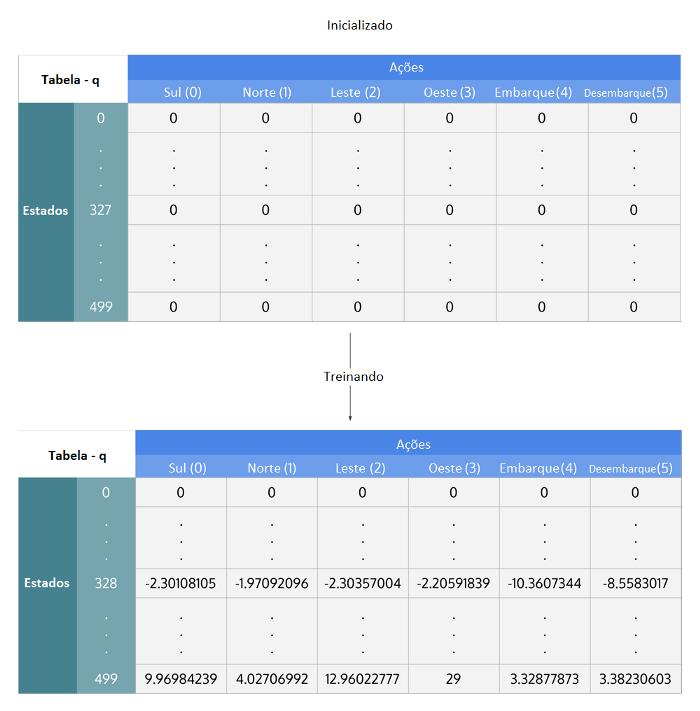

Inicialmente, a tabela preenchida com zeros e a cada iteração os valores são atualizados.

Passo-a-passo, fica:

   Inicializar a tabela-Q preenchida com zeros.
   
   Para as ações seguintes, há uma chance do agente tomá-las de forma aleatória ou seguir a política da tabela Estados x Ações.
  
  Após episódios suficientes, é esperado que o agente atinja uma política ótima e a tabela Estados x Ações esteja com os valores o mais próximo do ideal possível.

### Implementação em código


### Inicializando a tabela-q

Note aqui a razão de precisarmos ter um número finito de estados possíveis. Caso contrário não seria possível mapeá-los em uma tabela.


In [11]:
tabela_q = np.zeros([env.observation_space.n, env.action_space.n])

### Treinando o algoritmo

Aplicando tudo aquilo que acabamos de explicar, segue:


In [ ]:
#treinando o algoritmo

#aqui não existem valores "certos" ou "errados", decidimos por tentativa e erro aqueles que otimizaram o treinamento do nosso agente
alpha = 0.1
gamma = 0.6
epsilon = 0.1 #determina a chance do agente tomar uma ação aleatória, nesse caso a chance é de 10%

for i in range(1, 50001):
    estado = env.reset()

    epochs, penalidades, recompensa = 0, 0, 0 #epochs é cada episódio
    terminado = False
    
    while not terminado:
        if random.uniform(0, 1) < epsilon: #decidindo se será tomado uma ação aleatória ou se seguirá a política da tabela-q
            acao = env.action_space.sample() 
        else:
            acao = np.argmax(tabela_q[estado]) 

        proximo_estado, recompensa, terminado, info = env.step(acao) 
        
        valor_antigo = tabela_q[estado, acao]
        proximo_max = np.max(tabela_q[proximo_estado])
        
        valor_novo = (1 - alpha) * valor_antigo + alpha * (recompensa + gamma * proximo_max) #atualizando o valor de q a partir da equação de Bellman
        tabela_q[estado, acao] = valor_novo #colocando este valor na tabela-q

        if recompensa == -10: #contabilizando os embarques/desembarques errados
            penalidades += 1

        estado = proximo_estado
        epochs += 1
        
        clear_output(wait=True) #caso não queira ver o aprendizado comentar as 3 linhas seguintes, essa incluso
        env.render()
        sleep(.25)  #aumentar se quiser ver melhor o aprendizado (recomendado: .25)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episódios: {i}")
        #sleep(1)

print("Treinamento terminado.\n")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


Ao final da execução deste código, deverá montrar algo como: 
    
Episódios: 50000

Treinamento terminado.

### Testando o agente


Vamos então testar o nosso agente. Será que ele atingiu uma política ótima?

com a tabela-q atualizada, vejamos como o nosso agente se sai:


In [ ]:
#testando o algoritmo
epochs_totais, penalidades_totais = 0, 0
episodios = 100

for _ in range(episodios):
    estado = env.reset()
    epochs, penalidades, recompensa = 0, 0, 0
    
    terminado = False
    
    while not terminado:
        acao = np.argmax(tabela_q[estado])
        estado, recompensa, terminado, info = env.step(acao)

        if recompensa == -10:
            penalidades += 1

        epochs += 1
        
        clear_output(wait=True)
        env.render()
        sleep(.25)

    penalidades_totais += penalidades
    epochs_totais += epochs

print(f"Resutados depois de {episodios} episodios:")
print(f"Média de passos por episódio: {epochs_totais / episodios}")
print(f"Média de penalidades por episódio: {penalidades_totais / episodios}")

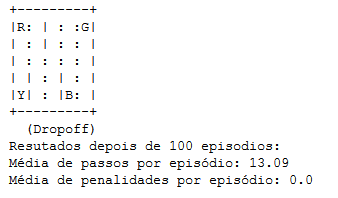

Dos 100 episódios testados, nosso agente não recebeu nenhuma penalidade, o que é um ótimo parâmetro para medirmos o sucesso de seu treinamento. Em relação a média de passos, também obtemos um bom valor (metade das casas do tabuleiro percorridas) tendo em vista a existência dos obstáculos.

Podemos perceber que a biblioteca Gym é uma ferramenta poderosa que facilita muito a vida de quem quer iniciar os estudos em Reinforcement Learning. Possui diferentes tipos de ambientes e suas principais funcionalidades fazendo a aplicação em um exemplo prático.

Além de ser essa ótima ferramenta para iniciantes, ela também é de grande valor no meio acadêmico. Isso porque, ao normalizar o espaço de trabalho que as pesquisas são desenvolvidas, ou seja estudos diferentes desenvolvidos no mesmo ambiente, torna-se mais fácil e de maior confiabilidade se comparar os resultados obtidos.

Destacamos uma implementar o Q-learning, um dos algoritmos mais simples de RL, ideal para os propósitos didáticos do post. Sua aplicação se limita a cenários com um número de estados finito e suficientemente pequeno. Caso esse valor se torne muito grande ou indefinido, devemos procurar outros métodos mais complexos de implementação de RL.

Atualmente, para resolver os problemas mais abstratos costuma-se usar as Deep Neural Networks que recebem na camada de entradas informações do estado e ações para poder aproximar um valor bom o suficiente para o q-value, mesmo sem levar em consideração todos os estados posteriores possíveis (até porque podem existir infinitos), aprendendo a retornar as ações corretas após treinamento suficiente.

Esse é o tipo de abordagem que se usa para treinar braços robóticos, jogos sem finais definidos como Flappy Bird, decidir preços praticados por uma empresa de acordo com as flutuações do mercado, gerenciamento de estoques ou realizar previsões no mercado financeiro. Note, portanto, que apesar da maior complexidade, a ideia central é a mesma apresentada em Q-learning.

Por fim, vamos voltar nossa atenção aos hiperparâmetros(α, γ e ε). Para decidi-los, tomamos uma abordagem de tentativa e erro. O ideal seria os ajustarmos de forma a diminuí-los com o passar do tempo, porém, por termos um espaço de estados tão pequeno, conseguimos atingir uma política ótima com valores estáticos. A justificativa para a diminuição de cada um é:

   α: quanto mais próximo do fim do treino, com uma base de conhecimento sobre o ambiente já consolidada, uma alta taxa de aprendizado torna-se menos relevante.
   γ: Quanto mais próximo do final do treinamento, o comportamento do agente para os finais dos episódios já estão bem definido e, se estiver aprendendo de forma correta, estará de acordo com o esperado. É interessante então melhorar o comportamento para as situações mais iniciais.
   ε: Quanto mais atualizada a tabela-q, menos o agente precisa explorar ações aleatórias.


Bons estudos!